基于2020年3月之前的疫情数据，建立时间序列RNN模型，对中国新冠肺炎疫情结束时间进行预测

In [1]:
import os
import datetime
import importlib 
import torchkeras

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. 数据准备

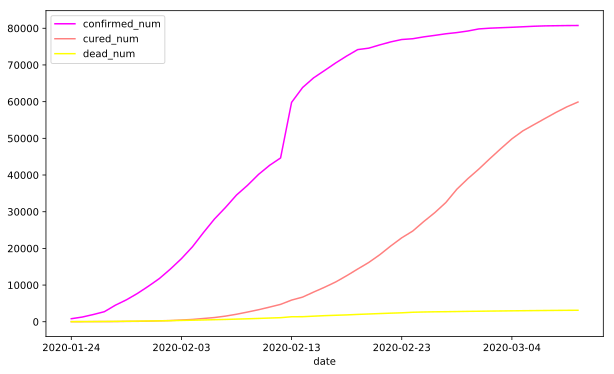

<Figure size 432x288 with 0 Axes>

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

df = pd.read_csv('./data/covid-19.csv', sep='\t')
df.plot(x='date', y=df.columns[1:].tolist(), figsize=(10, 6), colormap='spring')
plt.figure(facecolor='w')
plt.show()

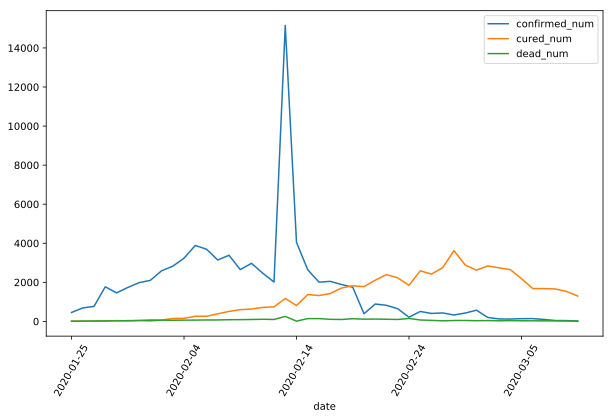

<Figure size 432x288 with 0 Axes>

In [10]:
data = df.set_index('date')
datadiff = data.diff(periods=1).dropna()   # 对临近数据作差，默认为行,差分结果为每日新增数
datadiff = datadiff.reset_index('date')    

datadiff.plot(x='date', y=df.columns[1:].tolist(), figsize=(10, 6))
plt.xticks(rotation=60)
plt.figure(facecolor='w')
plt.show()

datadiff = datadiff.drop('date', axis=1).astype('float32')

通过torch.utils.data.Dataset 实现自定义时间序列数据集，需要覆写两个方法
- \_\_len__: 实现len(dataset) 返回整个数据集的大小
- \_\_getitem__:实现通过索引来获取样本数据

In [11]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset


# 用某日前8天的窗口数据作为输入预测改日数据
WINDOW_SIZE = 8
class Covid19Dataset(Dataset):
    def __len__(self):
        return len(datadiff) - WINDOW_SIZE
    
    def __getitem__(self, i):
        x = datadiff.loc[i:i+WINDOW_SIZE - 1, :]
        feature = torch.tensor(x.values)
        y = datadiff.loc[i+WINDOW_SIZE, :]
        label = torch.tensor(y.values)
        return (feature, label)
    

ds_train = Covid19Dataset()
dl_train = DataLoader(ds_train,batch_size=38)

In [12]:
# 查看数据
ds_train[1]

(tensor([[6.8800e+02, 1.1000e+01, 1.5000e+01],
         [7.6900e+02, 2.0000e+00, 2.4000e+01],
         [1.7710e+03, 9.0000e+00, 2.6000e+01],
         [1.4590e+03, 4.3000e+01, 2.6000e+01],
         [1.7370e+03, 2.1000e+01, 3.8000e+01],
         [1.9810e+03, 4.7000e+01, 4.3000e+01],
         [2.0990e+03, 8.8000e+01, 3.0000e+01],
         [2.5890e+03, 6.9000e+01, 6.1000e+01]]), tensor([2825.,  147.,   57.]))

### 2. 定义模型
继承nn.Module基类构建自定义模型，使用类式训练循环

In [13]:
import torch
from torch import nn
import importlib
import torchkeras

In [28]:
torch.random.seed()


class Block(nn.Module):
    def __init__(self):
        super(Block, self).__init__()
        
    def forward(self, x, x_input):
        x_out = torch.max((1 + x) * x_input[:, -1, :], torch.tensor(.0))
        return x_out
    
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(
            input_size=3,
            hidden_size=3,
            num_layers=5,
            batch_first=True
        )
        self.linear = nn.Linear(3, 3)
        self.block = Block()
        
    def forward(self, x_input):
        x = self.lstm(x_input)[0][:, -1, :]
        x = self.linear(x)
        y = self.block(x, x_input)
        return y
        
        
net = Net()
model = torchkeras.Model(net)
print(net)

model.summary(input_shape=(8, 3), input_dtype=torch.FloatTensor)

Net(
  (lstm): LSTM(3, 3, num_layers=5, batch_first=True)
  (linear): Linear(in_features=3, out_features=3, bias=True)
  (block): Block()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              LSTM-1                 [-1, 8, 3]             480
            Linear-2                    [-1, 3]              12
             Block-3                    [-1, 3]               0
Total params: 492
Trainable params: 492
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000092
Forward/backward pass size (MB): 0.000229
Params size (MB): 0.001877
Estimated Total Size (MB): 0.002197
----------------------------------------------------------------


In [29]:
import torch
from torch import nn 
import importlib 
import torchkeras 

torch.random.seed()

class Block(nn.Module):
    def __init__(self):
        super(Block,self).__init__()
    
    def forward(self,x,x_input):
        x_out = torch.max((1+x)*x_input[:,-1,:],torch.tensor(0.0))
        return x_out
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3层lstm
        self.lstm = nn.LSTM(input_size = 3,hidden_size = 3,num_layers = 5,batch_first = True)
        self.linear = nn.Linear(3,3)
        self.block = Block()
        
    def forward(self,x_input):
        x = self.lstm(x_input)[0][:,-1,:]
        x = self.linear(x)
        y = self.block(x,x_input)
        return y
        
net = Net()
model = torchkeras.Model(net)
print(model)

model.summary(input_shape=(8,3),input_dtype = torch.FloatTensor)
    

Model(
  (net): Net(
    (lstm): LSTM(3, 3, num_layers=5, batch_first=True)
    (linear): Linear(in_features=3, out_features=3, bias=True)
    (block): Block()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              LSTM-1                 [-1, 8, 3]             480
            Linear-2                    [-1, 3]              12
             Block-3                    [-1, 3]               0
Total params: 492
Trainable params: 492
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000092
Forward/backward pass size (MB): 0.000229
Params size (MB): 0.001877
Estimated Total Size (MB): 0.002197
----------------------------------------------------------------


### 3. 训练模型

In [31]:
def mspe(y_pred, y_true):
    err_percent = (y_true - y_pred) ** 2 / torch.max(y_true ** 2, torch.tensor(1e-7))
    return torch.mean(err_percent)


model.compile(loss_func=mspe, optimizer=torch.optim.Adagrad(model.parameters(), lr=.1))

In [ ]:
dfhistory = model.fit(100, dl_train, log_step_freq=10)

### 4. 评估模型

In [33]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.figure(facecolor='w')
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()

c:\users\86132\appdata\local\programs\python\python37\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\users\86132\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


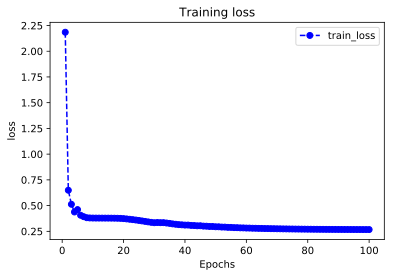

In [34]:
plot_metric(dfhistory, "loss")

### 五、使用模型

In [36]:
dfresult = datadiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


In [37]:
# 预测此后200天的新增走势,将其结果添加到dfresult中
for i in range(200):
    arr_input = torch.unsqueeze(torch.from_numpy(dfresult.values[-38:,:]),axis=0)
    arr_predict = model.forward(arr_input)

    dfpredict = pd.DataFrame(torch.floor(arr_predict).data.numpy(),
                columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)

In [40]:
dfresult['idx'] = list(range(dfresult.shape[0]))

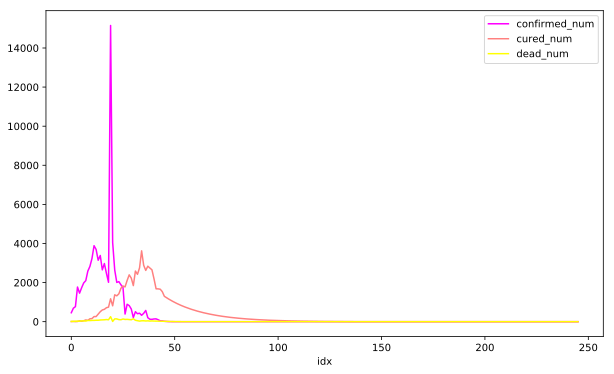

<Figure size 432x288 with 0 Axes>

In [41]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# df = pd.read_csv('./data/covid-19.csv', sep='\t')
dfresult.plot(x='idx', y=df.columns[1:].tolist(), figsize=(10, 6), colormap='spring')
plt.figure(facecolor='w')
plt.show()